<table style="border: none" align="center">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="4" color="black"><b>  Demonstrate detection of adversarial samples using ART  </b></font></font></th>
   </tr> 
</table>

In this notebook we demonstrate the detection of adversarial samples using ART. Our classifier will be a **ResNet** architecture for the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) image data set.


## Contents

1.	[Loading prereqs and data](#prereqs)
2.  [Evaluating the classifier](#classifier)
3.  [Training the detector](#train_detector)
4.  [Evaluating the detector](#detector)
5.  [Crazy stuff](#crazy)

<a id="prereqs"></a>
## 1. Loading prereqs and data

In [1]:
import warnings
warnings.filterwarnings('ignore')

from keras.models import load_model

from art.config import ART_DATA_PATH
from art.utils import load_dataset, get_file
from art.classifiers import KerasClassifier
from art.attacks import FastGradientMethod
from art.detection import BinaryInputDetector

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


Load the CIFAR10 data set and class descriptions:

In [2]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset('cifar10')

n_train = 200
n_test = 200
n_jobs = 4
x_train = x_train[:n_train]
y_train = y_train[:n_train]
x_test = x_test[:n_test]
y_test = y_test[:n_test]

class_descr = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

<a id="classifier"></a>
## 2. Evaluating the classifier

Load the pre-trained classifier (a ResNet architecture):

In [3]:
path = get_file('cifar_resnet.h5',extract=False, path=ART_DATA_PATH,
                url='https://www.dropbox.com/s/ta75pl4krya5djj/cifar_resnet.h5?dl=1')
classifier_model = load_model(path)
classifier = KerasClassifier(clip_values=(min_, max_), model=classifier_model, use_logits=False, 
                             preprocessing=(0.5, 1))

In [4]:
classifier_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

Evaluate the classifier on the first n_test test images:

In [5]:
x_test_pred = np.argmax(classifier.predict(x_test[:n_test]), axis=1)
nb_correct_pred = np.sum(x_test_pred == np.argmax(y_test[:n_test], axis=1))

print("Original test data (first n_test images):")
print("Correctly classified: {}".format(nb_correct_pred))
print("Incorrectly classified: {}".format(n_test-nb_correct_pred))

Original test data (first n_test images):
Correctly classified: 191
Incorrectly classified: 9


For illustration purposes, look at the first 9 images. (In brackets: true labels.)

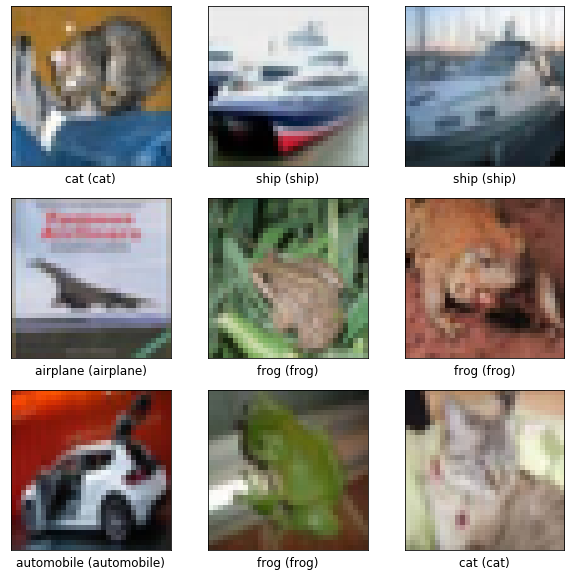

In [6]:
plt.figure(figsize=(10,10))
for i in range(0, 9):
    pred_label, true_label = class_descr[x_test_pred[i]], class_descr[np.argmax(y_test[i])]
    plt.subplot(330 + 1 + i)
    fig=plt.imshow(x_test[i])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.text(0.5, -0.1, pred_label + " (" + true_label + ")", fontsize=12, transform=fig.axes.transAxes, 
                  horizontalalignment='center')

Generate some adversarial samples:

In [7]:
attacker = FastGradientMethod(classifier, eps=0.05)
x_test_adv = attacker.generate(x_test[:n_test]) # this takes about two minutes

Evaluate the classifier on n_test adversarial samples:

In [8]:
x_test_adv_pred = np.argmax(classifier.predict(x_test_adv), axis=1)
nb_correct_adv_pred = np.sum(x_test_adv_pred == np.argmax(y_test[:n_test], axis=1))

print("Adversarial test data (first n_test images):")
print("Correctly classified: {}".format(nb_correct_adv_pred))
print("Incorrectly classified: {}".format(n_test-nb_correct_adv_pred))

Adversarial test data (first n_test images):
Correctly classified: 44
Incorrectly classified: 156


Now plot the adversarial images and their predicted labels (in brackets: true labels).

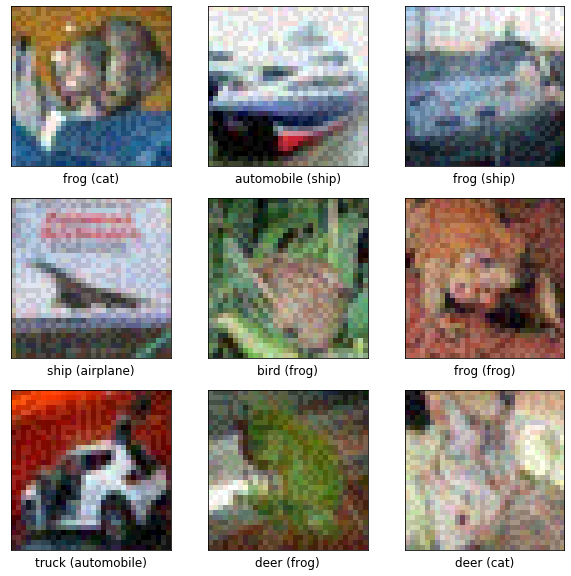

In [9]:
plt.figure(figsize=(10,10))
for i in range(0, 9):
    pred_label, true_label = class_descr[x_test_adv_pred[i]], class_descr[np.argmax(y_test[i])]
    plt.subplot(330 + 1 + i)
    fig=plt.imshow(x_test_adv[i])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.text(0.5, -0.1, pred_label + " (" + true_label + ")", fontsize=12, transform=fig.axes.transAxes, 
                  horizontalalignment='center')

<a id="train_detector"></a>
## 3. Training the detector

Load the detector model (which also uses a ResNet architecture):

In [10]:
path = get_file('BID_eps=0.05.h5',extract=False, path=ART_DATA_PATH,
                url='https://www.dropbox.com/s/cbyfk65497wwbtn/BID_eps%3D0.05.h5?dl=1')
detector_model = load_model(path)
detector_classifier = KerasClassifier(clip_values=(-0.5, 0.5), model=detector_model, use_logits=False)
detector = BinaryInputDetector(detector_classifier)

In [11]:
detector_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

To train the detector:
- we expand our training set with adversarial samples
- we label the data with 0 (original) and 1 (adversarial)

In [12]:
x_train_adv = attacker.generate(x_train)
nb_train = x_train.shape[0]

x_train_detector = np.concatenate((x_train, x_train_adv), axis=0)
y_train_detector = np.concatenate((np.array([[1,0]]*nb_train), np.array([[0,1]]*nb_train)), axis=0)

Perform the training:

In [13]:
detector.fit(x_train_detector, y_train_detector, nb_epochs=20, batch_size=20)

Epoch 1/20
20/20 [==============================] - 16s 776ms/step - loss: 0.0078 - accuracy: 1.0000
Epoch 2/20
20/20 [==============================] - 8s 413ms/step - loss: 0.0212 - accuracy: 0.9975
Epoch 3/20
20/20 [==============================] - 7s 357ms/step - loss: 0.0056 - accuracy: 1.0000
Epoch 4/20
20/20 [==============================] - 8s 390ms/step - loss: 0.0054 - accuracy: 1.0000
Epoch 5/20
20/20 [==============================] - 7s 370ms/step - loss: 0.0054 - accuracy: 1.0000
Epoch 6/20
20/20 [==============================] - 7s 341ms/step - loss: 0.0052 - accuracy: 1.0000
Epoch 7/20
20/20 [==============================] - 8s 388ms/step - loss: 0.0044 - accuracy: 1.0000
Epoch 8/20
20/20 [==============================] - 11s 545ms/step - loss: 0.0039 - accuracy: 1.0000
Epoch 9/20
20/20 [==============================] - 14s 688ms/step - loss: 0.0085 - accuracy: 0.9975
Epoch 10/20
20/20 [==============================] - 11s 533ms/step - loss: 0.0085 - accuracy: 0.

<a id="detector"></a>
## 4. Evaluating the detector

Apply the detector to the adversarial test data:

In [14]:
flag_adv = np.sum(np.argmax(detector.predict(x_test_adv), axis=1) == 1)

print("Adversarial test data (first n_test images):")
print("Flagged: {}".format(flag_adv))
print("Not flagged: {}".format(n_test - flag_adv))

Adversarial test data (first n_test images):
Flagged: 200
Not flagged: 0


Apply the detector to the first n_test original test images:

In [15]:
flag_original = np.sum(np.argmax(detector.predict(x_test[:n_test]), axis=1) == 1)

print("Original test data (first n_test images):")
print("Flagged: {}".format(flag_original))
print("Not flagged: {}".format(n_test - flag_original))

Original test data (first n_test images):
Flagged: 200
Not flagged: 0


Evaluate the detector for different attack strengths `eps`
(**Note**: for the training of detector, `eps=0.05` was used)

In [16]:
eps_range = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
nb_flag_adv = []
nb_missclass = []
all_x_test_adv = {}

for eps in eps_range:
    if eps > 0:
        attacker.set_params(**{'eps': eps})
        x_test_adv = attacker.generate(x_test[:n_test])
    else:
        x_test_adv = x_test
    all_x_test_adv[eps] = x_test_adv
    nb_flag_adv += [np.sum(np.argmax(detector.predict(x_test_adv), axis=1) == 1)]
    nb_missclass += [np.sum(np.argmax(classifier.predict(x_test_adv), axis=1) != np.argmax(y_test[:n_test],
                                                                                           axis=1))]
    
eps_range = eps_range
nb_flag_adv = nb_flag_adv
nb_missclass = nb_missclass

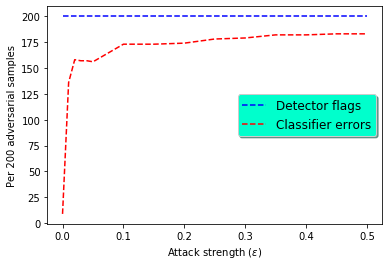

In [17]:
fig, ax = plt.subplots()
ax.plot(eps_range, nb_flag_adv, 'b--', label='Detector flags')
ax.plot(eps_range, nb_missclass, 'r--', label='Classifier errors')

legend = ax.legend(loc='center right', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Attack strength ($\\varepsilon$)')
plt.ylabel('Per %d adversarial samples' % n_test)
plt.show()

<a id="crazy"></a>
## 5. Crazy stuff

Now let's build a detector which simply looks at the intermediate activations of the host model. The feature vector of our detector will simply be a `FeatureUnion` of PCA transforms of these intermediate activations. The detector can run in both `supervised` and `unsupervised` modes, depending on whether `y` is provided or not during fitting. Everything will be done using `sklearn`

In [18]:
import typing

from sklearn.decomposition import PCA
from sklearn.base import clone, BaseEstimator, ClassifierMixin
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LogisticRegressionCV

import keras


class SklearnDetector(BaseEstimator, ClassifierMixin):
    def __init__(self, n_components=20, random_state=None, skip_layer_names=None):
        super(SklearnDetector, self).__init__()
        self.n_components = n_components
        self.random_state = random_state
        self.skip_layer_names = skip_layer_names
        
    def _skip_layer(self, layer):
        """
        Decides where layer should be included or excluded in analysis
        """
        bad_names = self.skip_layer_names
        if bad_names is None:
            bad_names = ["input", "flatten", "dropout", "add", "activation",
                         "classifier", "reshape", "concat"]
        layer_name = layer.name.lower()
        for bad_name in  bad_names:
            if bad_name in layer_name:
                return True
        else:
            return False

    def _get_classifier_output_tensors(self):
        layer_names = []
        outputs = []
        for layer in classifier_model.layers:
            if not self._skip_layer(layer):
                layer_names.append(layer.name)
                outputs.append(layer.output)
        self.layer_names = layer_names
        return outputs
        
    def _build_classifier_activation_model(self):
        """
        Build model for producing intermediate activations of the host classifier.
        """
        outputs = self._get_classifier_output_tensors()
        self.classifier_activation_model = keras.models.Model(input=classifier_model.input,
                                                              outputs=outputs)

    def _build_layer_pcas(self):
        """
        Build pca model for each intermediate activation layer of host classifier.
        """
        self.pcas = [PCA(n_components=self.n_components, random_state=self.random_state)
                     for _ in self.layer_names]

    def _build(self):
        self._build_classifier_activation_model()
        self._build_layer_pcas()

    def _get_classifier_activations(self, X, ravel=True) -> typing.List[np.array]:
        """
        Get the activation of each intermediate layer of the host classifier.
        """
        classifier_activations = self.classifier_activation_model.predict(X)
        if isinstance(classifier_activations, np.ndarray):
            # keras eats up dimension 0 of model output if model has only one ouput tensor!
            classifier_activations = [classifier_activations]
        if ravel:
            classifier_activations = [Z.reshape((len(Z), -1)) for Z in classifier_activations]
        return classifier_activations
    
    def _transform(self, classifier_activations):
        codes = []
        for pca, Z in zip(self.pcas, classifier_activations):
            codes.append(pca.transform(Z))
        return np.concatenate(codes, axis=1)

    def transform(self, X):
        """
        Get dimensionality-reduced intermediate activations of host classifier.
        """
        classifier_activations = self._get_classifier_activations(X)
        return self._transform(classifier_activations)
    
    def fit(self, X, y=None):
        """
        y: ndarray, optional (default None)
            If provided, we will, the detector will be a logistic-regression model (i.e supervised).
            Otherwise, the detector will be a one-class SVM (i.e unsupervided).
        """
        self._build()
        classifier_activations = self._get_classifier_activations(X)
        for classifier_layer_pca, Z in zip(self.pcas, classifier_activations):
            classifier_layer_pca.fit(Z)
        codes = self._transform(classifier_activations)

        if y is None:
            self.final = OneClassSVM()
        else:
            self.final = LogisticRegressionCV(cv=3, random_state=self.random_state)
        self.final.fit(codes, y)
        return self
    
    def predict(self, X):
        codes = self.transform(X)
        return self.final.predict(codes)

In [19]:
# can things be simplified ?

class SklearnDetectorLastHiddenLayer(SklearnDetector):
    """
    Only use activations from last hidden layer of host classifier
    """

    def _build_classifier_activation_model(self):
        outputs = self._get_classifier_output_tensors()
        self.layer_names = self.layer_names[-1:]
        outputs = outputs[-1:]
        self.classifier_activation_model = keras.models.Model(input=classifier_model.input,
                                                              outputs=outputs)
        
class SklearnDetectorFirstHiddenLayer(SklearnDetector):
    """
    Only use activations from first hidden layer of host classifier
    """
    
    def _build_classifier_activation_model(self):
        outputs = self._get_classifier_output_tensors()
        self.layer_names = self.layer_names[:1]
        outputs = outputs[:1]
        self.classifier_activation_model = keras.models.Model(input=classifier_model.input,
                                                              outputs=outputs)

In [309]:
# fit our detectors
my_detectors = {}
if F:
    n_components = 10
    y_detector_flat = 2 * y_train_detector.argmax(1) - 1
    # my_detectors["supervised"] = SklearnDetector(n_components=n_components).fit(x_train_detector, y_detector_flat)
    my_detectors["unsupervised"] = SklearnDetector(n_components=n_components).fit(x_train)
    # my_detectors["supervised_fhl"] = SklearnDetectorFirstHiddenLayer(
    # n_components=2 * n_components).fit(x_train_detector,  y_detector_flat)
    # my_detectors["unsupervised_fhl"] = SklearnDetectorFirstHiddenLayer(n_components=2 * n_components).fit(x_train)
    # my_detectors["supervised_lhl"] = SklearnDetectorLastHiddenLayer(
    #    n_components=2 * n_components).fit(x_train_detector,  y_detector_flat)
    # my_detectors["unsupervised_lhl"] = SklearnDetectorLastHiddenLayer(n_components=2 * n_components).fit(x_train)

Scores for unsupervised_lid detector
0.00 ==> 3.00
0.01 ==> 8.00
0.02 ==> 24.00
0.03 ==> 54.00
0.04 ==> 97.00
0.05 ==> 138.00
0.10 ==> 200.00
0.15 ==> 200.00
0.20 ==> 200.00
0.25 ==> 200.00
0.30 ==> 200.00
0.35 ==> 200.00
0.40 ==> 200.00
0.45 ==> 200.00
0.50 ==> 200.00


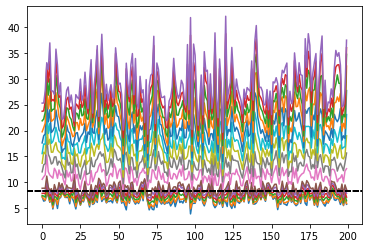

In [306]:
# evaluate the detectors
from sklearn.metrics import roc_auc_score, accuracy_score

def roc_auc_score_FIXED(y_true, y_pred):
    if len(np.unique(y_true)) == 1: # bug in roc_auc_score
        return accuracy_score(y_true, np.rint(y_pred))
    return roc_auc_score(y_true, y_pred)

# scores = {}
for which, my_detector in my_detectors.items():
    if which not in ["unsupervised_lid", "unsupervised"]:
        continue
    print("Scores for %s detector" % which)
    y_true = np.concatenate((-np.ones(n_test), np.ones(n_test)))
    if "unsupervised" in which:
        y_true = -y_true
    scores[which] = []
    for eps in all_x_test_adv:
        if False:
            if eps > 0:
                y_pred = my_detector.predict(np.vstack((x_test, all_x_test_adv[eps])))
                score = roc_auc_score_FIXED(y_pred, y_true)
            else:
                score = 0.5
        else:
            score = (my_detector.predict(all_x_test_adv[eps]) == -1).sum()
        print("%.2f ==> %.2f" % (eps, score))  
        if which not in scores:
            scores[which] = []
        scores[which].append(score)

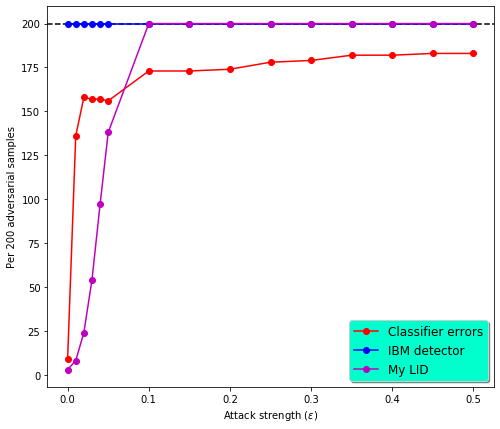

In [308]:
# plot the results
fig, ax = plt.subplots(figsize=(8, 7))
ax.axhline(n_test, linestyle="--", c="k")
ax.plot(eps_range, nb_missclass, 'r-o', label='Classifier errors')
ax.plot(eps_range, nb_flag_adv, 'b-o', label='IBM detector')
# ax.plot(eps_range, scores["supervised"], 'g-o', label='My sup. detector')
ax.plot(eps_range, scores["unsupervised"], 'm-o', label='My unsup. detector')
# ax.plot(eps_range, scores["supervised_fhl"], 'g--', label='My sup. first hidden layer detector')
# ax.plot(eps_range, scores["unsupervised_fhl"], 'm--', label='My unsup. first hidden layer detector')
# ax.plot(eps_range, scores["supervised_lhl"], 'g-.', label='My sup. last hidden layer detector')
# ax.plot(eps_range, scores["unsupervised_lhl"], 'm-.', label='My unsup. last hidden layer detector')
ax.plot(eps_range, scores["unsupervised_lid"], cm-o', label='My LID')

legend = ax.legend(loc='best', shadow=True, fontsize="large")
legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Attack strength ($\\varepsilon$)')
plt.ylabel('Per %d adversarial samples' % n_test)
plt.show()

We see that:

- IBM's detector solves the task perfectly. However, it will presumably be less accurate on attacks generated via another method
- Our supervised detector solves the task, but struggles with small values of the attack strength ($\varepsilon$).
- Neither the first hidden layer nor the last hidden layer is solely sufficient for detecting adversarial examples. We need all intermediate layer activations to solve the task!

In [ ]:
# compute the hidden representations used by our detectors
all_codes = []
which = "unsupervised"
for X in all_x_test_adv.values():
    codes = my_detectors[which].transform(X)
    all_codes.append(codes)
all_codes = np.concatenate(all_codes, axis=0)

In [ ]:
# visualize the hidden representations
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

from sklearn.manifold import TSNE

colors = np.concatenate([np.full(len(all_x_test_adv[eps]), eps) for eps in all_x_test_adv])
if False:
    visu = TSNE(n_components=3).fit_transform(all_codes)
else:
    visu = all_codes[:, -10:-7]
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
im = ax.scatter(*visu.T, c=colors)
cbar = plt.colorbar(im)
cbar.ax.set_ylabel("Attack strength ($\\varepsilon$)");
plt.title("Features for '%s' detector" % which)
plt.tight_layout()

In [ ]:
def monte_carlo(model, x, n_iter=100):
    import keras.backend as K
    f = K.function([model.input, K.learning_phase()],
                   [model.output])
    return [f((x, 1))[0] for _ in range(n_iter)]

In [ ]:
class UncertaintyDetector(BaseEstimator, ClassifierMixin):
    def __init__(self, random_state=None, mc_n_iter=20):
        super(UncertaintyDetector, self).__init__()
        self.random_state = random_state
        self.mc_n_iter = mc_n_iter
        
    def get_uncertainty(self, x):
        predictions = monte_carlo(classifier_model, x, n_iter=self.mc_n_iter)
        return np.var(predictions, axis=0)
    
    def fit(self, X, y=None):
        if y is None:
            self.final = OneClassSVM()
        else:
            self.final = LogisticRegressionCV(cv=3, random_state=self.random_state)
        
        uncertainty = self.get_uncertainty(X)
        self.final.fit(uncertainty, y)
        return self
        
    def predict(self, X):
        return self.final.predict(self.get_uncertainty(X))
                    

In [ ]:
my_detectors["supervised_uncertainty"] = UncertaintyDetector().fit(x_train_detector, y_detector_flat)

In [237]:
from scipy import linalg
from sklearn.utils.validation import check_is_fitted

class LIDDetector(BaseEstimator, ClassifierMixin):
    def __init__(self, layer_idx=0, k=10, threshold=1.3):
        super(LIDDetector, self).__init__()
        self.layer_idx = layer_idx
        self.k = k
        self.threshold = threshold
        self._build_activation_model()
        
    def _build_activation_model(self):
        self.activation_model_ = keras.models.Model(input=classifier_model.input,
                                                    output=classifier_model.layers[self.layer_idx].output)

    def _get_activations(self, X):
        if self.layer_idx == 0:
            return X
        return self.activation_model_.predict(X).reshape((len(X), -1))

    def fit(self, X, y=None):
        X = self._get_activations(X)
        self.knn_ = NearestNeighbors(n_neighbors=self.k, n_jobs=1, algorithm='ball_tree').fit(X)
        self.lids_ = self._compute_lids(X, remove_zero_dist=True)
        self.intrinsic_dim_ = self.lids_.mean()
        self.cutoff_ = self.threshold * self.intrinsic_dim_
        return self

    def _check_is_fitted(self):
        return check_is_fitted(self, attributes=["knn_"])
        
    def _compute_lids(self, X, remove_zero_dist=False):
        """
        Compute the Local Intrinsic Dimension (LID) of each sample in a batch
        """
        dist, _ = self.knn_.kneighbors(X)
        
        # handle zeros
        if remove_zero_dist:
            zero_mask = dist == 0.
            if zero_mask.sum():
                dist[zero_mask] = dist[~zero_mask].min()

        return np.reciprocal(np.log(dist[:, -1][:, None] / dist).mean(axis=-1))

    def predict(self, X, debug=True):
        self._check_is_fitted()
        X = self._get_activations(X)
        lids = self._compute_lids(X)
        if debug:
            plt.plot(lids)
            plt.axhline(self.cutoff_, linestyle="--", c="k")
        flags = np.ones(len(X))
        flags[lids >= self.cutoff_] = -1
        return flags
            

In [297]:
my_detectors["unsupervised_id"] = LIDDetector2(layer_idx=25).fit(x_train)
# my_detectors["unsupervised_id"] = IDDetector(layer_idx=25).fit(x_train)

In [298]:
my_detectors["unsupervised_lid"].cutoff_

8.295962636537492

141

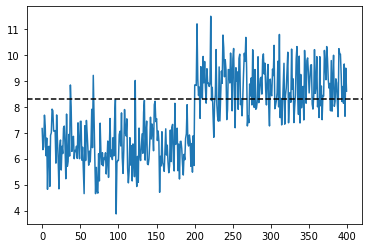

In [300]:
(my_detectors["unsupervised_lid"].predict(np.concatenate((x_test, all_x_test_adv[0.05]), axis=0)) == -1).sum()

In [295]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors

class IDDetector(LIDDetector):
    def _compute_mus(self, X):
        dist, _ = self.knn_.kneighbors(X)
        assert dist.shape[1] == 3
        dist = dist[:, 1:]
        return dist[:, 1] / dist[:, 0]  # ratio of distance from 2nd nearest to nearest point
    
    def _check_is_fitted(self):
        return check_is_fitted(self, attributes=["intrinsic_dim_"])

    def fit(self, X):
        X = self._get_activations(X).reshape((len(X), -1))
        self.knn_ = NearestNeighbors(n_neighbors=2+1, n_jobs=1, algorithm='ball_tree').fit(X)
        mus = self._compute_mus(X)
        mus.sort()
        F = np.arange(1, len(X) + 1) / float(len(X))
        self.xx_ = np.log(mus)
        self.yy_ = -np.log(1 - F)
        lr = LinearRegression(fit_intercept=False)
        self.intrinsic_dim_ = lr.fit(self.xx_[:-1][:, None], self.yy_[:-1]).coef_[0]
        self.cutoff_ = self.threshold * self.intrinsic_dim_
        return self

In [245]:
class LIDDetector2(LIDDetector):
    def __init__(self, layer_idx=0, k1=10, k2=20, threshold=1.3):
        super(LIDDetector2, self).__init__(layer_idx=layer_idx, threshold=threshold)
        self.k1 = k1
        self.k2 = k2

    def _check_is_fitted(self):
        return check_is_fitted(self, attributes=["lider_"])
    
    def _compute_lids(self, X):
        return self.lider_.predict(X)
    
    def fit(self, X):
        X = self._get_activations(X)
        self.lider_ = LocalIntrinsicDimensionMLE(k1=self.k1, k2=self.k2).fit(X)  
        self.intrinsic_dim_ = self.lider_.intrinsic_dims_.mean()
        self.cutoff_ = self.threshold * self.intrinsic_dim_
        return self

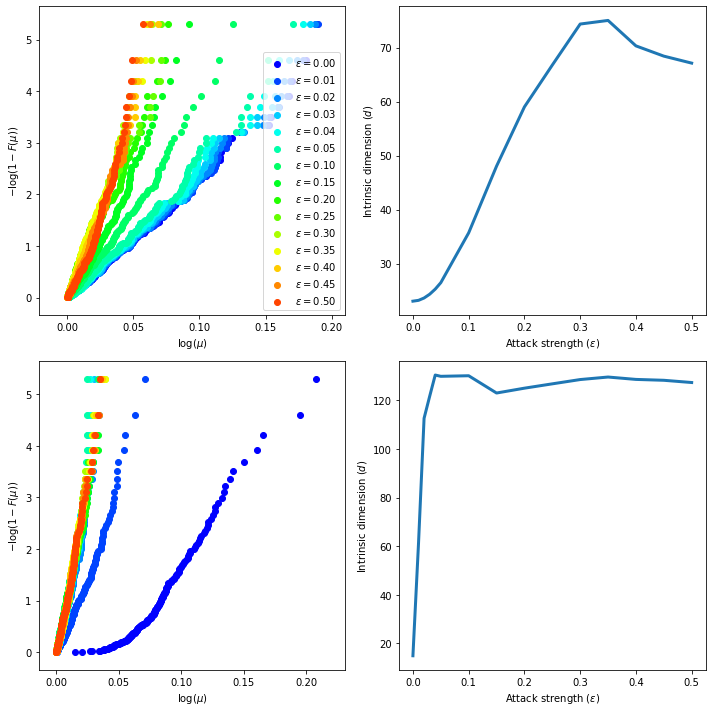

In [296]:
from colour import Color
blue = Color("blue")
colors = list(blue.range_to(Color("red"), 1 + len(all_x_test_adv)))
colors = [np.array(color.get_rgb())[None, :] for color in colors]
layer_indices = [0, 25]
_, axes = plt.subplots(len(layer_indices), 2, figsize=(2 * 5, len(layer_indices) * 5))
legended = False
for layer_idx, (ax1, ax2) in zip(layer_indices, axes):
    ids = []
    toto = IDDetector(layer_idx=layer_idx)
    for eps, c in zip(all_x_test_adv, colors):
        toto.fit(all_x_test_adv[eps])
        ax1.scatter(toto.xx_, toto.yy_, label="$\\varepsilon=%.2f$" % eps, c=c)
        ids.append(toto.intrinsic_dim_)

    ax1.set_xlabel("$\\log(\\mu)$")
    ax1.set_ylabel("$-\\log(1-F(\\mu))$")
        
    if not legended:
        legended = True
        ax1.legend(loc="best", ncol=1)
            
    ax2.plot(eps_range, ids, linewidth=3)
    ax2.set_xlabel("Attack strength ($\\varepsilon$)")
    ax2.set_ylabel("Intrinsic dimension ($d$)")
plt.tight_layout()
plt.savefig("intrinsic.png", dpi=200, bbox_inches="tight")

In [ ]:
my_detectors["unsupervised_id"].d_

In [ ]:
x = np.random.randn(2000, 6)
x /= linalg.norm(x, axis=-1)[:, None]
if x.shape[1] == 2:
    plt.scatter(*x.T)

In [ ]:
toto = IDDetector(layer_idx=25).fit(x_train)
toto.d_

In [48]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors


def intrinsic_dim_sample_wise(X, k=5, dist=None):
    """
    Returns Levina-Bickel dimensionality estimation
    
    Input parameters:
    X    - data
    k    - number of nearest neighbours (Default = 5)
    dist - matrix of distances to the k nearest neighbors of each point (Optional)
    
    Returns: 
    dimensionality estimation for the k 
    """
    if dist is None:
        knn = NearestNeighbors(n_neighbors=k+1, n_jobs=1, algorithm='ball_tree').fit(X)
        dist, _ = knn.kneighbors(X)
    dist = dist[:, 1:(k+1)]
    assert dist.shape == (X.shape[0], k)
    assert np.all(dist > 0)
    d = np.log(dist[:, k - 1: k] / dist[:, 0:k - 1])
    d = d.sum(axis=1) / (k - 2)
    d = 1. / d
    intdim_sample = d
    return intdim_sample


def intrinsic_dim_scale_interval(X, k1=10, k2=20, dist=None, knn=None):
    """
    Returns range of Levina-Bickel dimensionality estimation for k = k1..k2, k1 < k2
    
    Input parameters:
    X    - data
    k1   - minimal number of nearest neighbours (Default = 10)
    k2   - maximal number of nearest neighbours (Default = 20)
    
    Returns: 
    list of Levina-Bickel dimensionality estimation for k = k1...k2
    """
    if dist is None:
        if knn is None:
            knn = NearestNeighbors(n_neighbors=k2+1, n_jobs=1, algorithm='ball_tree').fit(X)
        dist, _ = knn.kneighbors(X)
        
    intdim_k = []
    for k in range(k1, k2 + 1):
        m = intrinsic_dim_sample_wise(X, k, dist=dist)
        intdim_k.append(m)
    return np.asanyarray(intdim_k), knn


39.89456586249569


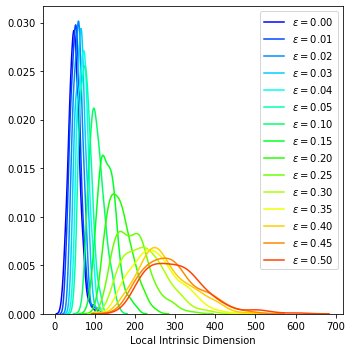

In [292]:
class LocalIntrinsicDimensionMLE(BaseEstimator):
    def __init__(self, k1=10, k2=20, preprocessor=None):
        super(LocalIntrinsicDimensionMLE, self).__init__()
        self.k1 = k1
        self.k2 = k2
        self.preprocessor = preprocessor
        
    def fit(self, X):
        if self.preprocessor is not None:
            X = self.preprocessor(X)
        intrinsic_dims, self.knn_ = intrinsic_dim_scale_interval(X, k1=self.k1, k2=self.k2)
        self.intrinsic_dims_ = intrinsic_dims.mean(axis=0)
        return self

    def predict(self, X):
        if self.preprocessor is not None:
            X = self.preprocessor(X)
        intrinsic_dims, _ = intrinsic_dim_scale_interval(X, k1=self.k1, k2=self.k2, knn=self.knn_) 
        return intrinsic_dims.mean(axis=0)
    
layer_idx = 25
colors = list(blue.range_to(Color("red"), 1 + len(all_x_test_adv)))
colors = [np.array(color.get_rgb())[None, :] for color in colors]
activation_model = keras.models.Model(input=classifier_model.input,
                                      output=classifier_model.layers[layer_idx].output)
lid = LocalIntrinsicDimensionMLE(preprocessor=lambda X: activation_model.predict(X).reshape((len(X), -1)))
lid.fit(x_train)
print(lid.intrinsic_dims_.mean())
ids = []
import seaborn as sns
plt.figure(figsize=(5, 5))
for eps, color in zip(eps_range, colors):
    d = lid.predict(all_x_test_adv[eps])
    sns.kdeplot(d, c=color[0], label="$\\varepsilon=%.2f$" % eps)
    ids.append(d)
plt.legend(loc="best")
plt.xlabel("Local Intrinsic Dimension")
plt.tight_layout()
# plt.plot(eps_range, ids)

Text(0, 0.5, 'Local Intrinsic Dimension')

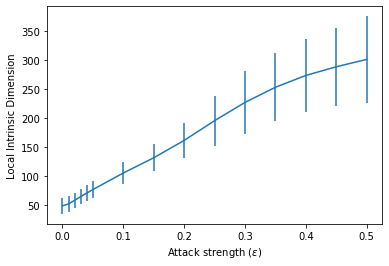

In [293]:
plt.errorbar(eps_range, np.mean(ids, axis=1), yerr=np.std(ids, axis=1))
plt.xlabel("Attack strength ($\\varepsilon$)")
plt.ylabel("Local Intrinsic Dimension")

In [69]:
ids

[14.938996373075941,
 61.068252404847016,
 112.66435360857274,
 121.68164096605953,
 130.46702997958892,
 129.94068727031365,
 130.1767043389748,
 123.06627430424696,
 125.05901487568121,
 126.84269430573345,
 128.60761018277307,
 129.64486299629596,
 128.66654822011313,
 128.30806096742032,
 127.3884525678736]

In [139]:
x = np.random.randn(1000, 21)
x /= linalg.norm(x, axis=1)[:, None]
lid = LocalIntrinsicDimensionMLE2NN()
lid.fit(x)
lid.intrinsic_dim_

16.573826751370667

In [86]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors

class LocalIntrinsicDimensionMLE2NN(LocalIntrinsicDimensionMLE):
    def _compute_mus(self, X):
        dist, _ = self.knn_.kneighbors(X)
        assert dist.shape[1] == 3
        dist = dist[:, 1:]
        return dist[:, 1] / dist[:, 0]  # ratio of distance from 2nd nearest to nearest point

    def fit(self, X):
        if self.preprocessor is not None:
            X = self.preprocessor(X)
        self.knn_ = NearestNeighbors(n_neighbors=2+1, n_jobs=1, algorithm='ball_tree').fit(X)
        mus = self._compute_mus(X)
        mus.sort()
        F = np.arange(1, len(X) + 1) / float(len(X))
        self.xx_ = np.log(mus)
        self.yy_ = -np.log(1 - F)
        lr = LinearRegression(fit_intercept=False)
        self.intrinsic_dim_ = lr.fit(self.xx_[:-1][:, None], self.yy_[:-1]).coef_[0]
        return self
    
    def predict(self, X):
        if self.preprocessor is not None:
            X = self.preprocessor(X)
        dist, _ = self.knn_.neighbors(X)
        return np.reciprocal(np.log(dist[:, -1][:, None] / dist).mean(axis=-1))

In [165]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression, Ridge
from functools import partial

def tolist(x):
    if type(x) in {int, float}:
        return [x]
    if type(x) in {list, tuple}:
        return list(x)
    if type(x) == np.ndarray:
        return x.tolist()

def drop_zero_values(dist):
    mask = dist[:,0] == 0
    dist[mask] = np.hstack([dist[mask][:, 1:], dist[mask][:,0:1]])
    dist = dist[:, :-1]
    assert np.all(dist > 0)
    return dist
    
def mle_center(X, X_center, k=5, dist=None):
    """
    Returns Levina-Bickel dimensionality estimation
    
    Input parameters:
    X        - data points
    X_center - data centers
    k        - number of nearest neighbours (Default = 5)
    dist     - matrix of distances to the k nearest neighbors of each point (Optional)
    
    Returns: 
    dimensionality estimation for the k 
    """
    if len(X_center.shape) != 2:
        X_center = X_center.values.reshape(1, -1)
    if dist is None:
        neighb = NearestNeighbors(n_neighbors=k+1, n_jobs=1,
                                  algorithm='ball_tree').fit(X)
        dist, ind = neighb.kneighbors(X_center)
        dist = drop_zero_values(dist)
    dist = dist[:, 0:k]
    assert dist.shape == (X_center.shape[0], k)
    assert np.all(dist > 0)
    d = np.log(dist[:, k - 1: k] / dist[:, 0:k - 1])
    d = d.sum(axis=1) / (k - 2)
    d = 1. / d
    intdim_sample = d
    Rs = dist[:, -1]
    return intdim_sample, Rs

def fit_poly_reg(x, y, w=None, degree=(1, 2), alpha=5e-3):
    """
    Fit regression and return f(0) 
    
    Input parameters:
    x - features (1d-array) 
    y - targets (1d-array)
    w - weights for each points (Optional)
    degree - degrees of polinoms (Default tuple(1, 2))
    alpha - parameter of regularization (Default 5e-3)
    Returns: 
    zero coefficiend of regression
    """
    X = np.array([x ** i for i in tolist(degree)]).T
    lm = Ridge(alpha=alpha)
    lm.fit(X, y, w)
    return lm.intercept_

def _func(df, degree, alpha):
    gr_df = df.groupby('k')
    R = gr_df['R'].mean().values
    d = gr_df['dim'].mean().values
    std = gr_df['dim'].std().values
    if np.isnan(std).any(): std = np.ones_like(std) 
    return fit_poly_reg(R, d, std**-1, degree=degree, alpha=alpha)

def geomle(X, k1=10, k2=40, knns=None, nb_iter1=10, nb_iter2=20, degree=(1, 2),
           alpha=5e-3, ver='GeoMLE', random_state=None, debug=False):
    """
    Returns range of Levina-Bickel dimensionality estimation for k = k1..k2 (k1 < k2)
    averaged over bootstrap samples
    
    Input parameters:
    X            - data
    k1           - minimal number of nearest neighbours (Default = 10)
    k2           - maximal number of nearest neighbours (Default = 40)
    nb_iter1     - number of bootstrap iterations (Default = 10)
    nb_iter1     - number of bootstrap iterations for each regresion (Default = 20)
    degree       - (Default = (1, 2))
    alpha        - (Default = 5e-3)
    random_state - random state (Optional)
    
    Returns: 
    array of shape (nb_iter1,) of regression dimensionality estimation for k = k1..k2
    averaged over bootstrap samples
    """
    if random_state is None:
        rng = np.random
    else:
        rng = np.random.RandomState(random_state)
    nb_examples = X.shape[0]
    dim_space = X.shape[1]

    result = []
    data_reg = []
    if knns is not None:
        nb_iter1 = len(knns)
        nb_iter2 = len(knns[0])
        knns_ = knns
    else:
        knns_ = {}
    for i in range(nb_iter1):
        dim_all, R_all, k_all, idx_all = [], [], [], []
        if knns is None:
            knns_[i] = {}
        for j in range(nb_iter2):
            if knns:
                X_bootstrap, neighb = knns[i][j]
            else:
                idx = np.unique(rng.randint(0, nb_examples - 1, size=nb_examples))
                X_bootstrap = X.iloc[idx]
                neighb = NearestNeighbors(n_neighbors=k2+1, n_jobs=1,
                                          algorithm='ball_tree').fit(X_bootstrap)
                knns_[i][j] = X_bootstrap, neighb
            dist, ind = neighb.kneighbors(X)
            dist = drop_zero_values(dist)
            dist = dist[:, 0:k2]
            assert np.all(dist > 0)

            for k in range(k1, k2+1):
                dim, R = mle_center(X_bootstrap, X, k, dist)
                dim_all += dim.tolist()
                R_all += R.tolist()
                idx_all += list(range(nb_examples))
                k_all += [k] * dim.shape[0] 
        
        data={'dim': dim_all,
              'R': R_all,
              'idx': idx_all,
              'k': k_all}
        
        df = pd.DataFrame(data)
        if ver == 'GeoMLE':
            func = partial(_func, degree=degree, alpha=alpha)
            reg = df.groupby('idx').apply(func).values.mean()
            data_reg.append(df)
        elif ver == 'fastGeoMLE':
            df_gr = df.groupby(['idx', 'k']).mean()[['R', 'dim']]
            R = df_gr.groupby('k').R.mean()
            d = df_gr.groupby('k').dim.mean()
            std = df_gr.groupby('k').dim.std()
            reg = fit_poly_reg(R, d, std**-1, degree=degree, alpha=alpha)
            data_reg.append((R, d, std))
        else:
            assert False, 'Unknown mode {}'.format(ver)
        reg = 0 if reg < 0 else reg
        reg = dim_space if reg > dim_space else reg
        result.append(reg)
    if debug:
        return np.array(result), data_reg, knns_
    else:
        return np.array(result), knns_



In [167]:
import pandas as pd
dims, knns = geomle(pd.DataFrame(x), nb_iter2=1, nb_iter1=10, ver="fastGeoMLE")
print(dims.mean())

20.601267483916054


In [171]:
geomle(pd.DataFrame(x[-10:]), knns=knns, ver="fastGeoMLE")[0].mean()

12.045335756974826

In [179]:
classifier_model.layers[25].output.shape

TensorShape([None, 32, 32, 16])

In [291]:
(x_train, y_train), _, _, _ = load_dataset('cifar10')
x_train, y_train = x_train[:1000], y_train[:1000]
